## 0.前言

日化.xlsx 这个数据集是美妆类商品的订单数据，从数量来看，应该是批发类的订单。包含两个 sheet 页（订单表和商品表），可以挖掘的纬度有日期、地区、商品，指标则有销售量、销售额、增长率等。

## 1.导入库 读取数据

In [24]:
import pandas as pd
import pandas_profiling as pdp
import matplotlib as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

In [25]:
# 读取数据
order = pd.read_excel('日化.xlsx', sheet_name='销售订单表')
product = pd.read_excel('日化.xlsx', sheet_name='商品信息表')
# pdp.ProfileReport(product)

## 2.数据清洗
查看数据的基本情况，确认是否有缺失，重复，并进行对应的处理

### 2.1 订单表数据清洗

In [26]:
order.head()# 查看前几行数据

,订单编码,订单日期,客户编码,所在区域,所在省份,所在地市,商品编号,订购数量,订购单价,金额
0,D31313,2019-05-16 00:00:00,S22796,东区,浙江省,台州市,X091,892,214,190888.0
1,D21329,2019-05-14 00:00:00,S11460,东区,安徽省,宿州市,X005,276,185,51060.0
2,D22372,2019-08-26 00:00:00,S11101,北区,山西省,忻州市,X078,1450,116,168200.0
3,D31078,2019-04-08 00:00:00,S10902,北区,吉林省,延边朝鲜族自治州,X025,1834,102,187068.0
4,D32470,2019-04-11 00:00:00,S18696,北区,北京市,北京市,X010,887,58,51446.0


In [27]:
order.info() # 查看数据总体情况

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31452 entries, 0 to 31451
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   订单编码    31452 non-null  object 
 1   订单日期    31452 non-null  object 
 2   客户编码    31452 non-null  object 
 3   所在区域    31450 non-null  object 
 4   所在省份    31450 non-null  object 
 5   所在地市    31452 non-null  object 
 6   商品编号    31451 non-null  object 
 7   订购数量    31450 non-null  object 
 8   订购单价    31448 non-null  object 
 9   金额      31448 non-null  float64
dtypes: float64(1), object(9)
memory usage: 2.4+ MB


In [28]:
order[order.duplicated()].count() # 查看重复数据的数量

订单编码    6
订单日期    6
客户编码    6
所在区域    6
所在省份    6
所在地市    6
商品编号    6
订购数量    6
订购单价    6
金额      6
dtype: int64

In [29]:
order.drop_duplicates(inplace=True)   # 删除重复数据
order.reset_index(drop=True, inplace=True)  # 重建索引
order.isnull().sum()  # 查看空值，有几条数据缺失

订单编码    0
订单日期    0
客户编码    0
所在区域    2
所在省份    2
所在地市    0
商品编号    1
订购数量    2
订购单价    4
金额      4
dtype: int64

In [30]:
order.fillna(method='bfill', inplace=True) # 空值填充
order.fillna(method='ffill', inplace=True) # 空值填充
order.isnull().sum()  # 查看空值，有几条数据缺失

订单编码    0
订单日期    0
客户编码    0
所在区域    0
所在省份    0
所在地市    0
商品编号    0
订购数量    0
订购单价    0
金额      0
dtype: int64

In [31]:
order['订单日期'] = order['订单日期'].apply(lambda x: pd.to_datetime(x, format='%Y#%m#%d') if isinstance(x, str) else x)
order[order['订单日期'] > '2021-01-01'] # 有一条脏数据

,订单编码,订单日期,客户编码,所在区域,所在省份,所在地市,商品编号,订购数量,订购单价,金额
20797,D26533,2050-06-09,S21396,北区,河北省,石家庄市,X022,759,158,119922.0


In [32]:
order = order[order['订单日期'] < '2021-01-01'] # 过滤掉脏数据
order['订单日期'].max(), order['订单日期'].min()  # 数据区间在 2019-01-01 到 2019-09-30 之间

(Timestamp('2019-09-30 00:00:00'), Timestamp('2019-01-01 00:00:00'))

In [33]:
order['订购数量'] = order['订购数量'].apply(lambda x: x.strip('个') if isinstance(x, str) else x).astype('int')
order['订购单价'] = order['订购单价'].apply(lambda x: x.strip('元') if isinstance(x, str) else x).astype('float')
order['金额'] = order['金额'].astype('float')

In [34]:
order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31445 entries, 0 to 31445
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   订单编码    31445 non-null  object        
 1   订单日期    31445 non-null  datetime64[ns]
 2   客户编码    31445 non-null  object        
 3   所在区域    31445 non-null  object        
 4   所在省份    31445 non-null  object        
 5   所在地市    31445 non-null  object        
 6   商品编号    31445 non-null  object        
 7   订购数量    31445 non-null  int32         
 8   订购单价    31445 non-null  float64       
 9   金额      31445 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), object(6)
memory usage: 2.5+ MB


In [35]:
order['所在省份'] = order['所在省份'].str.replace(r'自治区|维吾尔|回族|壮族|省|市', '',regex=True)  # 对省份做个清洗，便于可视化
order['所在省份'].unique()

array(['浙江', '安徽', '山西', '吉林', '北京', '云南', '广东', '广西', '内蒙古', '新疆', '湖北',
       '江苏', '甘肃', '四川', '河南', '福建', '陕西', '辽宁', '山东', '江西', '重庆', '河北',
       '湖南', '上海', '贵州', '天津', '海南', '宁夏', '黑龙江'], dtype=object)

In [36]:
order['客户编码'] = order['客户编码'].str.replace('编号', '')

### 2.2商品表数据清洗

In [37]:
product.head()

,商品编号,商品名称,商品小类,商品大类,销售单价
0,X001,商品1,面膜,护肤品,121
1,X002,商品2,面膜,护肤品,141
2,X003,商品3,面膜,护肤品,168
3,X004,商品4,面膜,护肤品,211
4,X005,商品5,面膜,护肤品,185


In [38]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   商品编号    122 non-null    object
 1   商品名称    122 non-null    object
 2   商品小类    122 non-null    object
 3   商品大类    122 non-null    object
 4   销售单价    122 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 4.9+ KB


In [39]:
product[product.duplicated()].count()  # 没有完全重复的数据

商品编号    0
商品名称    0
商品小类    0
商品大类    0
销售单价    0
dtype: int64

In [40]:
product[product['商品编号'].duplicated()].count() # ID 唯一没有重复

商品编号    0
商品名称    0
商品小类    0
商品大类    0
销售单价    0
dtype: int64

In [41]:
product.isnull().sum()   # 没有空值 

商品编号    0
商品名称    0
商品小类    0
商品大类    0
销售单价    0
dtype: int64

## 3.数据分析可视化

### 3.1每月订购情况

<AxesSubplot:title={'center':'每月订购情况'}, xlabel='订单月份'>

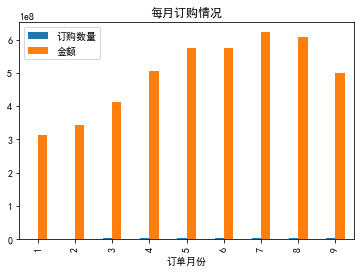

In [42]:
order['订单月份'] = order['订单日期'].apply(lambda x: x.month) 
item = order.groupby('订单月份').agg({'订购数量': 'sum', '金额': 'sum'})

item.plot(kind="bar",title="每月订购情况")

### 3.2哪里的人最爱美

<AxesSubplot:title={'center':'订单排行榜Top20'}, ylabel='所在地市'>

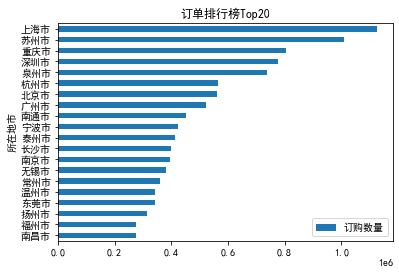

In [43]:
item = (order
        .groupby('所在地市')
        .agg({'订购数量': 'sum'})
        .sort_values(by='订购数量', ascending=False)[:20]
        .sort_values(by='订购数量')[:20]
       )
item.plot(kind="barh",title="订单排行榜Top20")

### 3.3什么类型的美妆需求量最大

In [44]:
order_new = pd.merge(order, product, on='商品编号',how='inner')  # 表关联
order_new

,订单编码,订单日期,客户编码,所在区域,所在省份,所在地市,商品编号,订购数量,订购单价,金额,订单月份,商品名称,商品小类,商品大类,销售单价
0,D31313,2019-05-16,S22796,东区,浙江,台州市,X091,892,214.0,190888.0,5,商品91,粉底,彩妆,214
1,D26674,2019-05-01,S15128,东区,江苏,南通市,X091,1133,214.0,242462.0,5,商品91,粉底,彩妆,214
2,D23381,2019-09-22,S17133,东区,江苏,宿迁市,X091,1136,214.0,243104.0,9,商品91,粉底,彩妆,214
3,D29060,2019-09-10,S14106,东区,江苏,常州市,X091,544,214.0,116416.0,9,商品91,粉底,彩妆,214
4,D21234,2019-07-03,S17197,东区,湖北,十堰市,X091,342,214.0,73188.0,7,商品91,粉底,彩妆,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31439,D30482,2019-06-05,S11033,东区,浙江,金华市,X118,551,238.0,131138.0,6,商品118,蜜粉,彩妆,238
31440,D29542,2019-05-01,S12446,东区,江苏,南通市,X118,165,238.0,39270.0,5,商品118,蜜粉,彩妆,238
31441,D24798,2019-06-26,S16170,南区,福建,泉州市,X118,62,238.0,14756.0,6,商品118,蜜粉,彩妆,238
31442,D31831,2019-08-13,S22214,北区,黑龙江,佳木斯市,X118,795,238.0,189210.0,8,商品118,蜜粉,彩妆,238


In [45]:
(order_new
 .groupby(['商品大类','商品小类'])
 .agg({'订购数量': 'sum'})
 .sort_values(by=['商品大类', '订购数量'], ascending=[True, False])
)

订购数量
商品大类 商品小类         
彩妆   口红    2013024
     粉底    1188621
     睫毛膏    587399
     眼影     296599
     蜜粉      45534
护肤品  面膜    5451914
     面霜    4566905
     爽肤水   3523687
     眼霜    3350743
     隔离霜   2488124
     防晒霜   2388610
     洁面乳   1928020

### 3.4哪些省份的美妆需求量最大

<AxesSubplot:title={'center':'订购数量'}, ylabel='所在省份'>

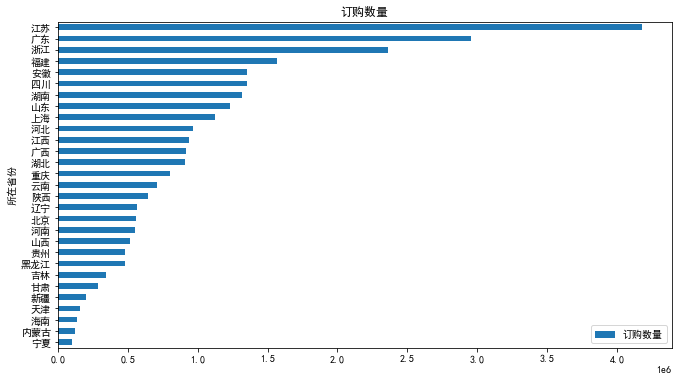

In [56]:
item = order.groupby('所在省份').agg({'订购数量': 'sum'}).sort_values(by="订购数量")
item.plot(kind="barh",title="订购数量",figsize=(11,6))

### 3.5 通过RFM模型挖掘客户价值
RFM 模型是衡量客户价值和客户创利能力的重要工具和手段，其中由3个要素构成了数据分析最好的指标，分别是：

- R-Recency（最近一次购买时间）
- F-Frequency（消费频率）
- M-Money（消费金额）

设定一个计算权重，比如 R-Recency 20% F-Frequency 30% M-Money 50% ，最后通过这个权重进行打分，量化客户价值，后续还可以基于分数进一步打标签，用来指导二次营销的策略。

In [58]:
rfm = (order
       .groupby('客户编码')
       .agg({
           '订单日期': 'max', 
           '订单编码': 'count', 
           '金额': 'sum'})
      )
rfm.columns = ['最近一次购买时间', '消费频率', '消费金额']

In [60]:
rfm['R'] = rfm['最近一次购买时间'].rank(pct=True)   # 转化为排名 百分比，便于后续切片
rfm['F'] = rfm['消费频率'].rank(pct=True)
rfm['M'] = rfm['消费金额'].rank(pct=True)
rfm.sort_values(by='R', ascending=False) 

,最近一次购买时间,消费频率,消费金额,R,F,M
客户编码,,,,,,
S11609,2019-09-30,42,7326027.0,0.980148,0.796399,0.903970
S19828,2019-09-30,21,2642275.0,0.980148,0.356879,0.306556
S17166,2019-09-30,17,3627037.0,0.980148,0.261311,0.478301
S22925,2019-09-30,31,3449117.0,0.980148,0.591413,0.457987
S10469,2019-09-30,30,4198071.0,0.980148,0.570175,0.564174
...,...,...,...,...,...,...
S16503,2019-04-07,14,1682893.0,0.004617,0.198061,0.146814
S17547,2019-03-14,10,1784531.0,0.003232,0.087258,0.163435
S20864,2019-03-14,8,1118752.0,0.003232,0.039243,0.047091


In [61]:
rfm['score'] = rfm['R'] * 20 + rfm['F'] * 30 + rfm['M'] * 50
rfm['score'] = rfm['score'].round(1)
rfm.sort_values(by='score', ascending=False) 

,最近一次购买时间,消费频率,消费金额,R,F,M,score
客户编码,,,,,,,
S17476,2019-09-30,69,10325832.0,0.980148,0.986611,0.987073,98.6
S22326,2019-09-30,62,10074609.0,0.980148,0.973223,0.984303,98.0
S11581,2019-09-28,79,10333668.0,0.918283,0.996768,0.987996,97.7
S12848,2019-09-29,66,9673572.0,0.944598,0.980609,0.980609,97.3
S19095,2019-09-26,81,11031632.0,0.864728,0.999077,0.996307,97.1
...,...,...,...,...,...,...,...
S12690,2019-05-07,7,917233.0,0.012927,0.022622,0.024931,2.2
S11176,2019-06-09,7,614134.0,0.036011,0.022622,0.009234,1.9
S18379,2019-07-05,4,400195.0,0.071099,0.003232,0.004617,1.7


根据这个分数结果，我们可以对客户打上一些标签，比如大于 80 分的，标志为优质客户，在资源有限的情况下，可以优先服务好优质客户。